### Model Exercises

The end result of this exercise should be a Jupyter notebook named model.

Using saas.csv or log data from API usage or store_item_sales

In [1]:
import numpy as np
import pandas as pd

#working with dates/tsa
from datetime import datetime
import statsmodels.api as sm
from statsmodels.tsa.api import Holt

# evaluate performance using rmse
from sklearn.metrics import mean_squared_error
from math import sqrt

#for visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

# turn off warning boxes for presentation purposes
import warnings
warnings.filterwarnings("ignore")

In [2]:
# read csv to a dataframe
df = pd.read_csv('GlobalLandTemperaturesbyState.csv')

#look at initial rows, transposed
df.head().T
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 645675 entries, 0 to 645674
Data columns (total 5 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   dt                             645675 non-null  object 
 1   AverageTemperature             620027 non-null  float64
 2   AverageTemperatureUncertainty  620027 non-null  float64
 3   State                          645675 non-null  object 
 4   Country                        645675 non-null  object 
dtypes: float64(2), object(3)
memory usage: 24.6+ MB


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 645675 entries, 0 to 645674
Data columns (total 5 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   dt                             645675 non-null  object 
 1   AverageTemperature             620027 non-null  float64
 2   AverageTemperatureUncertainty  620027 non-null  float64
 3   State                          645675 non-null  object 
 4   Country                        645675 non-null  object 
dtypes: float64(2), object(3)
memory usage: 24.6+ MB


#### Takeaways for Prepping Data: 
1. dt to datetime
2. set index
3. sort values by date
4. keep only City of San Antonio data
5. drop unnecessary columns (Texas and US)


In [4]:
def wrangle_txtemps():
    
    '''
    This function reads the Global Land Temperatures by State data from csv 
    into a data frame. It removes data for all other states except Texas, renames 
    the dt column to "Date", converts Date to datetime object, sorts it by date and 
    sets Date as the index of the dataframe. Unnecessary columns of State and
    Country are removed and a dataframe with only Texas data is returned.
    '''
    
    # read csv to a dataframe
    df = pd.read_csv('GlobalLandTemperaturesbyState.csv')
    
    # keep only Texas data
    df = df[df.State == 'Texas']
    
    #rename dt column to Date and other columns for readability
    df.rename(columns = {'dt': 'Date', 
                         'AverageTemperature':'Average_Temp',
                         'AverageTemperatureUncertainty':'Average_Uncertainty'}, 
                          inplace = True)
    
    # convert dt datetime format
    df['Date'] = pd.to_datetime(df.Date)
    
    # sort values by date
    df = df.sort_values('Date')
    
    # set index
    df = df.set_index('Date')

    # drop unneccesary columns of State and Country
    df = df.drop(columns=['State', 'Country'])
    
    return df
    


In [5]:
df = wrangle_txtemps()
df.head(2)

,Average_Temp,Average_Uncertainty
Date,,
1820-01-01,4.489,3.369
1820-02-01,9.081,2.873


In [6]:
# check that for data shape and type and nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2325 entries, 1820-01-01 to 2013-09-01
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Average_Temp         2325 non-null   float64
 1   Average_Uncertainty  2325 non-null   float64
dtypes: float64(2)
memory usage: 54.5 KB


In [7]:
# ensure all Date entries are unique (no duplicates) 
df.value_counts('Date')

Date
2013-09-01    1
1886-06-01    1
1884-10-01    1
1884-09-01    1
1884-08-01    1
             ..
1949-02-01    1
1949-01-01    1
1948-12-01    1
1948-11-01    1
1820-01-01    1
Length: 2325, dtype: int64

#### 1. Split data (train/validate/test) and resample by any period, except daily, and aggregate using the sum.

In [8]:
# train size will be 50% of the total
train_size = int(len(df) * .5)
train_size

1162

In [9]:
# validate will be 30% of total entries
validate_size = int(len(df) * .3)
validate_size

697

In [10]:
# test size will be the remaining rows
test_size = int(len(df) - train_size - validate_size)
test_size

466

In [11]:
# validate will start at 1162 and go through 1162+697 (train + validate)
validate_end_index = train_size + validate_size
validate_end_index

1859

In [12]:
# use the above values to split our data

# train will go from 0 to 1161
train = df[: train_size]

# validate will go from 1162 to 1858
validate = df[train_size:validate_end_index]

# test will include 1859 to the end
test = df[validate_end_index:]

#### Verifying splits are correct

In [13]:
# verifying splits 
print(len(train) + len(validate) + len(test) == len(df))

True


In [14]:
#is first row of df qual to first row of train?
print(df.head(1) == train.head(1))

            Average_Temp  Average_Uncertainty
Date                                         
1820-01-01          True                 True


In [15]:
#Is the last row of train the month before the first row of validate?
pd.concat([train.tail(1), validate.head(1)])

,Average_Temp,Average_Uncertainty
Date,,
1916-10-01,18.745,0.222
1916-11-01,11.975,0.162


In [16]:
#Is the last row of validate the month before the first row of test?
pd.concat([validate.tail(1), test.head(1)])

,Average_Temp,Average_Uncertainty
Date,,
1974-11-01,12.392,0.326
1974-12-01,7.870,0.247


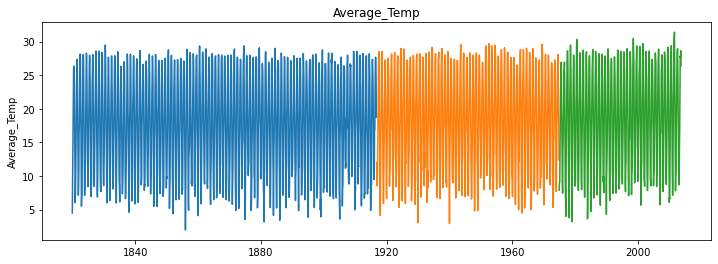

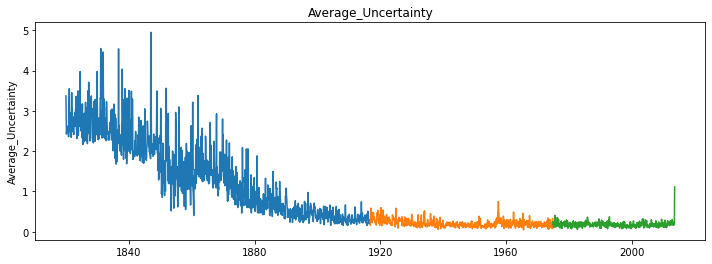

In [17]:
# verifying splits with visualization
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

In [18]:
y = train.Average_Temp

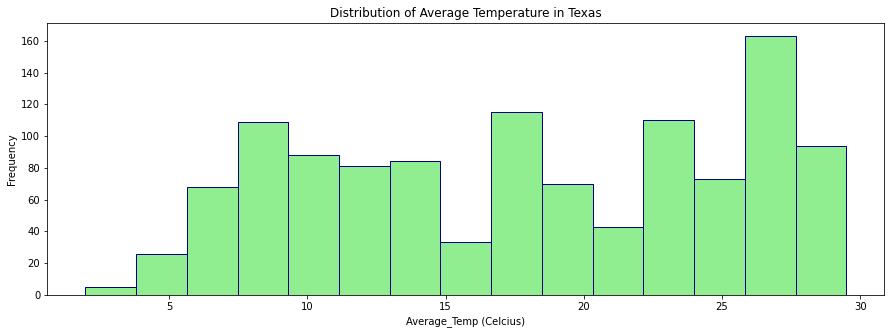

In [19]:
#look at distribution of our target variable
plt.figure(figsize=(15, 5))
train.Average_Temp.plot.hist(bins = 15, color = 'lightgreen', edgecolor = 'darkblue')
plt.xlabel('Average_Temp (Celcius)')
plt.title('Distribution of Average Temperature in Texas')
plt.show()

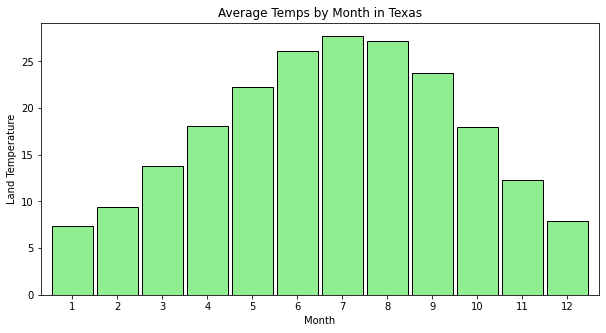

In [20]:
### Explore Average by month
plt.figure(figsize=(10, 5))
ax = y.groupby(y.index.month).mean().plot.bar(width=.9, color = 'lightgreen', ec='black')
plt.xticks(rotation=0)
ax.set(title='Average Temps by Month in Texas', xlabel='Month', ylabel='Land Temperature')
plt.show()

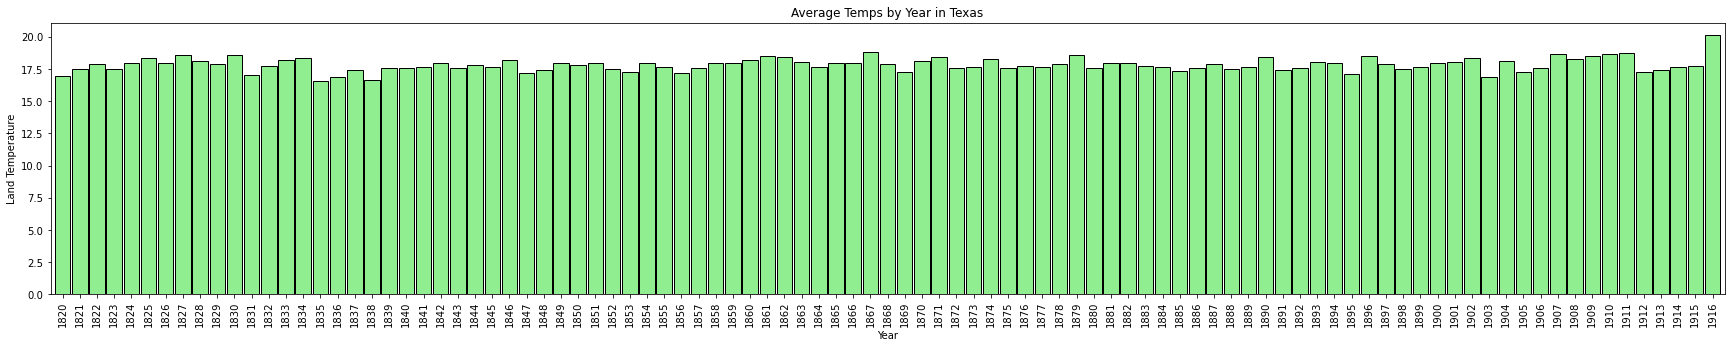

In [61]:
### Explore Average by year
plt.figure(figsize=(30, 5))
ax = y.groupby(y.index.year).mean().plot.bar(width=.9, color = 'lightgreen', ec='black')
plt.xticks(rotation=90)
ax.set(title='Average Temps by Year in Texas', xlabel='Year', ylabel='Land Temperature')
plt.show()

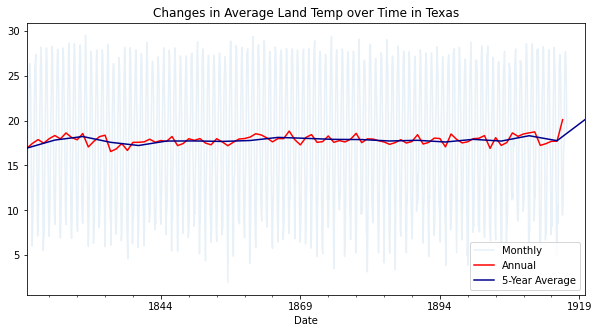

In [22]:
# Visualize target over time - monthly, yearly, decade
plt.figure(figsize=(10, 5))
plt.title('Changes in Average Land Temp over Time in Texas')
y.plot(alpha=.1, label='Monthly')
# y.resample('M').mean().plot(alpha=.5, label='Monthly', color = 'tan')
y.resample('Y').mean().plot(label='Annual', color = 'red')
y.resample('5Y').mean().plot(label='5-Year Average', color = 'darkblue')
# y.resample('10Y').mean().plot(label='Decade', color = 'yellow')
plt.legend()
plt.show()

#### 2. Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:
- Simple Average
- Moving Average
- Holt's Linear Trend Model
- Based on previous year/month/etc., this is up to you.

In [23]:
# convert Celcius temp to Fahrenheit

def c_to_f(c):
    '''
    this function takes in a Celcius temperature and converts it to Fahrenheit
    '''
    f = (c * 1.8) + 32
    return f

In [24]:
#evaluate function will compute MSE and RMSE

def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 4)
    return rmse

In [25]:
# plot and eval function will use the evaluate function ^^^ and also 
# plot train and test values with the predicted values in order to compare performance

def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will also label the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.4f}'.format(rmse))
    plt.show()

write append_eval_df(model_type) to append evaluation metrics for each model type, target variable, and metric type, along with the metric value into our eval_df data frame object. Which we will create an empty eval_df dataframe object to start.


In [26]:
# create an empty dataframe
eval_df = pd.DataFrame(columns=['model_type','target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [27]:
#function to store the rmse so that we can compare

def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [28]:
eval_df

,model_type,target_var,rmse


### Simple Average
- this simply takes the average of historical values and uses that to predict future values.
- Each future datapoint (test data) will be assigned the value of the mean in train.
- good option for an initial baseline

<AxesSubplot:xlabel='Date'>

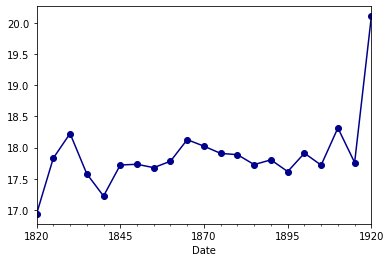

In [29]:
y.resample('5Y').mean().plot(label='5-Year Average', color = 'darkblue', marker = 'o')

In [30]:
# compute the simple average of train temps
temps = round(train['Average_Temp'].mean(),1)
temps

17.8

In [31]:
# compute the simple average of train uncertainty
uncert = round(train['Average_Uncertainty'].mean(),2)
uncert

1.39

In [32]:
# apply predictions to our observations
def make_predictions():
    yhat_df = pd.DataFrame({'Average_Temp': [temps], 'Average_Uncertainty':[uncert]}, index = validate.index)
    return yhat_df



In [33]:
yhat_df = make_predictions()

In [34]:
yhat_df.head()

,Average_Temp,Average_Uncertainty
Date,,
1916-11-01,17.8,1.39
1916-12-01,17.8,1.39
1917-01-01,17.8,1.39
1917-02-01,17.8,1.39
1917-03-01,17.8,1.39


In [35]:
yhat_df.describe()

,Average_Temp,Average_Uncertainty
count,6.970000e+02,6.970000e+02
mean,1.780000e+01,1.390000e+00
std,1.635422e-13,1.155461e-14
min,1.780000e+01,1.390000e+00
25%,1.780000e+01,1.390000e+00
50%,1.780000e+01,1.390000e+00
75%,1.780000e+01,1.390000e+00
max,1.780000e+01,1.390000e+00


#### Plot Actual Temperature v. Predicted Temperature using **Simple Average**

Average_Temp -- RMSE: 7.3985


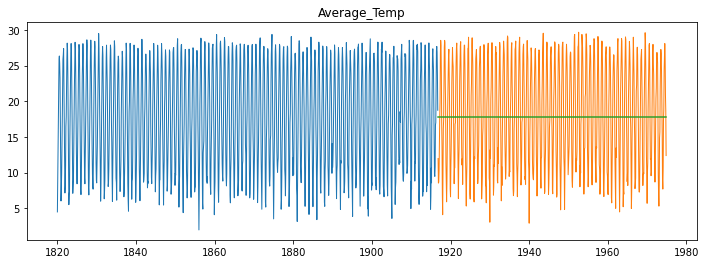

Average_Uncertainty -- RMSE: 1.1822


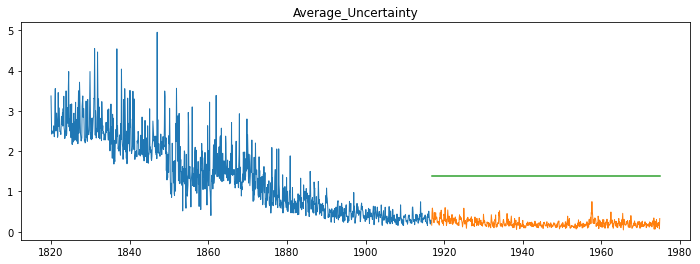

In [36]:
for col in train.columns:
    plot_and_eval(col)

In [37]:
eval_df

,model_type,target_var,rmse


In [38]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                            target_var = col)
eval_df

,model_type,target_var,rmse
0,simple_average,Average_Temp,7.3985
1,simple_average,Average_Uncertainty,1.1822


### Moving Average

- using a 12-month moving average to forecast. 
- this means the average over the last 12-months will be used as the forecasted value.

In [39]:
# look at the last 12-months on the train data -- the average of these will be used as our forecasted value
train['Average_Temp'].tail(12)

Date
1915-11-01    14.400
1915-12-01     9.772
1916-01-01     9.471
1916-02-01    10.864
1916-03-01    16.670
1916-04-01    17.024
1916-05-01    22.842
1916-06-01    27.134
1916-07-01    27.693
1916-08-01    26.943
1916-09-01    23.658
1916-10-01    18.745
Name: Average_Temp, dtype: float64

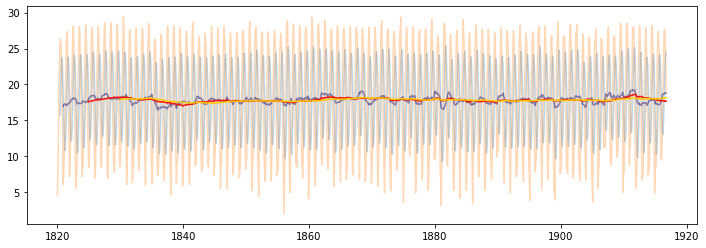

In [40]:
plt.figure(figsize=(12,4))
plt.plot(train['Average_Temp'].rolling(6).mean(), alpha = .3)
plt.plot(train['Average_Temp'].rolling(12).mean(), alpha = .5, color = 'darkblue')
plt.plot(train['Average_Temp'].rolling(60).mean(), color = 'red')
plt.plot(train['Average_Temp'].rolling(120).mean(), color = 'gold')
plt.plot(train['Average_Temp'], alpha=.3)

#### Making Predictions using Rolling Average - 12 months

In [41]:
period = 12 

# take 12 month rolling average, then take the last element and that will the one that propogates 
# forward as our prediction. 
temps = round(train['Average_Temp'].rolling(period).mean()[-1], 2)
uncert = round(train['Average_Uncertainty'].rolling(period).mean()[-1], 2)

print(temps, uncert)

18.77 0.33


In [42]:
yhat_df = make_predictions()
yhat_df.head()

,Average_Temp,Average_Uncertainty
Date,,
1916-11-01,18.77,0.33
1916-12-01,18.77,0.33
1917-01-01,18.77,0.33
1917-02-01,18.77,0.33
1917-03-01,18.77,0.33


**Plot Actual vs. Predicted Values** using Rolling Average

Average_Temp -- RMSE: 7.4002


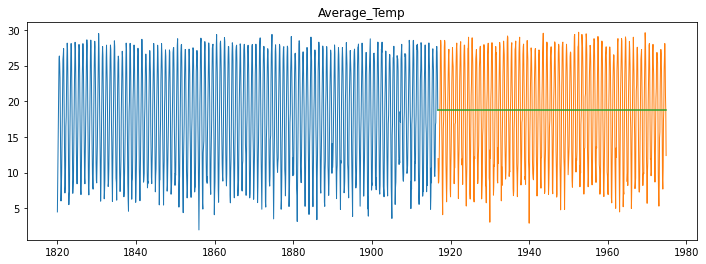

Average_Uncertainty -- RMSE: 0.1492


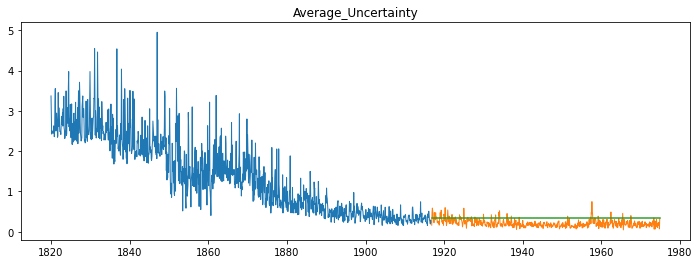

In [43]:
for col in train.columns:
    plot_and_eval(col)

In [44]:
# Evaluate using MSE and RMSE, and add evaluation metrics to our eval dataframe
for col in train.columns:
    eval_df = append_eval_df(model_type = '12_month_moving_avg', 
                            target_var = col)

eval_df

,model_type,target_var,rmse
0,simple_average,Average_Temp,7.3985
1,simple_average,Average_Uncertainty,1.1822
2,12_month_moving_avg,Average_Temp,7.4002
3,12_month_moving_avg,Average_Uncertainty,0.1492


#### Making Predictions using Rolling Average - 60 months

In [45]:
period = 60 

# take 60 month rolling average, then take the last element and that will the one that propogates 
# forward as our prediction. 
temps = round(train['Average_Temp'].rolling(period).mean()[-1], 2)
uncert = round(train['Average_Uncertainty'].rolling(period).mean()[-1], 2)

print(temps, uncert)

17.65 0.33


In [46]:
yhat_df = make_predictions()
yhat_df.head()

,Average_Temp,Average_Uncertainty
Date,,
1916-11-01,17.65,0.33
1916-12-01,17.65,0.33
1917-01-01,17.65,0.33
1917-02-01,17.65,0.33
1917-03-01,17.65,0.33


**Plot Actual vs. Predicted Values** using Rolling Average

Average_Temp -- RMSE: 7.4095


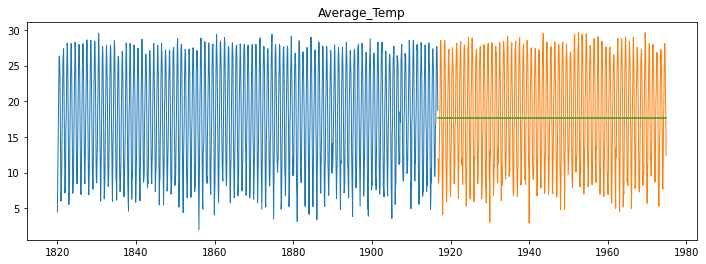

Average_Uncertainty -- RMSE: 0.1492


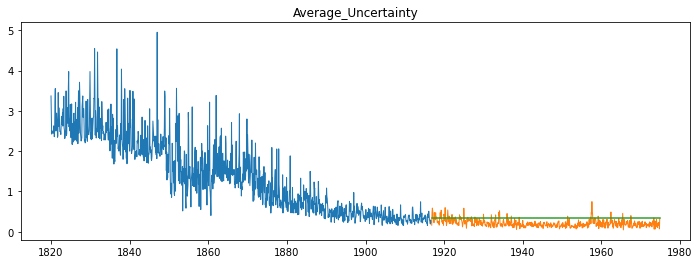

In [47]:
for col in train.columns:
    plot_and_eval(col)

In [48]:
# Evaluate using MSE and RMSE, and add evaluation metrics to our eval dataframe
for col in train.columns:
    eval_df = append_eval_df(model_type = '60_month_moving_avg', 
                            target_var = col)

eval_df

,model_type,target_var,rmse
0,simple_average,Average_Temp,7.3985
1,simple_average,Average_Uncertainty,1.1822
2,12_month_moving_avg,Average_Temp,7.4002
3,12_month_moving_avg,Average_Uncertainty,0.1492
4,60_month_moving_avg,Average_Temp,7.4095
5,60_month_moving_avg,Average_Uncertainty,0.1492


#### Making Predictions using Rolling Average - 120 months

In [49]:
period = 120 

# take 120 month rolling average, then take the last element and that will the one that propogates 
# forward as our prediction. 
temps = round(train['Average_Temp'].rolling(period).mean()[-1], 2)
uncert = round(train['Average_Uncertainty'].rolling(period).mean()[-1], 2)

print(temps, uncert)

18.15 0.32


In [50]:
yhat_df = make_predictions()
yhat_df.head()

,Average_Temp,Average_Uncertainty
Date,,
1916-11-01,18.15,0.32
1916-12-01,18.15,0.32
1917-01-01,18.15,0.32
1917-02-01,18.15,0.32
1917-03-01,18.15,0.32


**Plot Actual vs. Predicted Values** using Rolling Average

Average_Temp -- RMSE: 7.3844


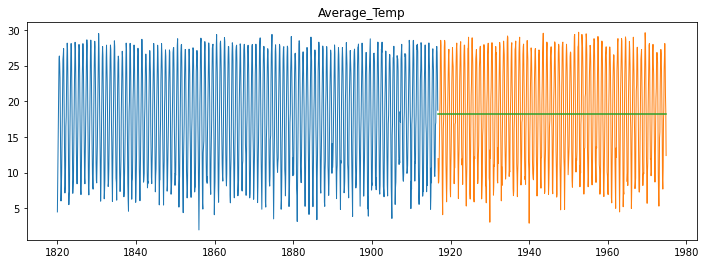

Average_Uncertainty -- RMSE: 0.1414


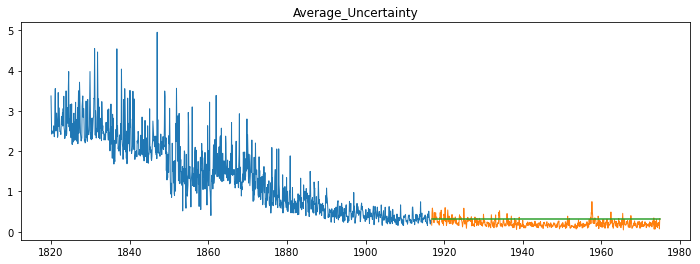

In [51]:
for col in train.columns:
    plot_and_eval(col)

In [52]:
# Evaluate using MSE and RMSE, and add evaluation metrics to our eval dataframe
for col in train.columns:
    eval_df = append_eval_df(model_type = '120_month_moving_avg', 
                            target_var = col)

eval_df

,model_type,target_var,rmse
0,simple_average,Average_Temp,7.3985
1,simple_average,Average_Uncertainty,1.1822
2,12_month_moving_avg,Average_Temp,7.4002
3,12_month_moving_avg,Average_Uncertainty,0.1492
4,60_month_moving_avg,Average_Temp,7.4095
5,60_month_moving_avg,Average_Uncertainty,0.1492
6,120_month_moving_avg,Average_Temp,7.3844
7,120_month_moving_avg,Average_Uncertainty,0.1414


#### Making Predictions using Rolling Average - 6 months

In [53]:
period = 6 

# take 6 month rolling average, then take the last element and that will the one that propogates 
# forward as our prediction. 
temps = round(train['Average_Temp'].rolling(period).mean()[-1], 2)
uncert = round(train['Average_Uncertainty'].rolling(period).mean()[-1], 2)

print(temps, uncert)

24.5 0.25


In [54]:
yhat_df = make_predictions()
yhat_df.head()

,Average_Temp,Average_Uncertainty
Date,,
1916-11-01,24.5,0.25
1916-12-01,24.5,0.25
1917-01-01,24.5,0.25
1917-02-01,24.5,0.25
1917-03-01,24.5,0.25


**Plot Actual vs. Predicted Values** using Rolling Average

Average_Temp -- RMSE: 9.6596


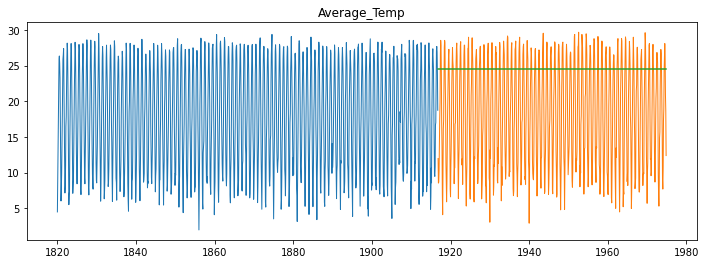

Average_Uncertainty -- RMSE: 0.0983


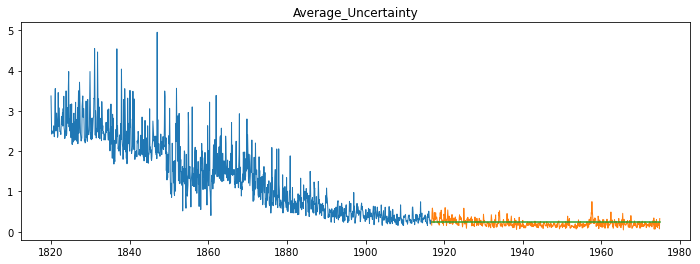

In [55]:
for col in train.columns:
    plot_and_eval(col)

In [56]:
# Evaluate using MSE and RMSE, and add evaluation metrics to our eval dataframe
for col in train.columns:
    eval_df = append_eval_df(model_type = '6_month_moving_avg', 
                            target_var = col)

eval_df

,model_type,target_var,rmse
0,simple_average,Average_Temp,7.3985
1,simple_average,Average_Uncertainty,1.1822
2,12_month_moving_avg,Average_Temp,7.4002
3,12_month_moving_avg,Average_Uncertainty,0.1492
4,60_month_moving_avg,Average_Temp,7.4095
5,60_month_moving_avg,Average_Uncertainty,0.1492
6,120_month_moving_avg,Average_Temp,7.3844
7,120_month_moving_avg,Average_Uncertainty,0.1414
8,6_month_moving_avg,Average_Temp,9.6596
9,6_month_moving_avg,Average_Uncertainty,0.0983


### Holt's Linear Trend
- Applies exponential smoothing to both the average and the trend, or slope.
- $\alpha$ / smoothing_level: smoothing parameter for mean. Values closer to 1 will have less of a smoothing effect and will give greater weight to recent values.   
- $\beta$ / smoothing_slope: smoothing parameter for the slope. Values closer to 1 will give greater weight to recent slope/values. 

**Seasonal Decomposition**
First, let's take a look at the seasonal decomposition for each target. 

In [57]:
import statsmodels.api as sm

Average_Temp 



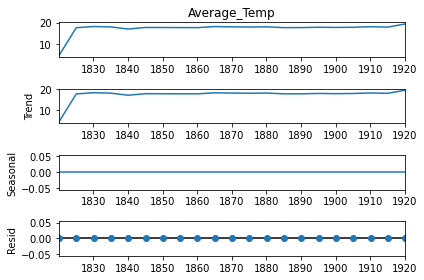

Average_Uncertainty 



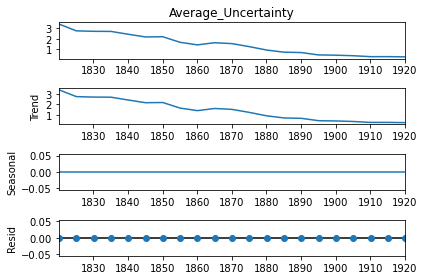

In [58]:
for col in train.columns:
    print(col, '\n')
    sm.tsa.seasonal_decompose(train[col].resample('60m').mean()).plot()
    plt.show()

#### Basic Holt's Linear Trend

**Make Predictions**

Now, like we would when using sklearn, we will create the Holt object, fit the model, and make predictions. 

Holt: 

- exponential = True/False (exponential vs. linear growth, additive vs. multiplicative)
- damped $\phi$ = True/False: with Holt, forecasts will increase or decrease indefinitely into the future.  To avoid this, use the Damped trend method which has a damping parameter 0< ϕ <1. 


fit: 

- smoothing_level ($\alpha$): value between (0,1)
- smoothing_slope ($\beta$): value between (0,1)
- optimized: use the auto-optimization that allow statsmodels to automatically find an optimized value for us. 

In [62]:
# doing this in a loop for each column, but we could separate out for clarity if needed. 
for col in train.columns:
    model = Holt(train[col], exponential=False, damped=True)
    model = model.fit(optimized=True)
    yhat_temps = model.predict(start = validate.index[0],
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_temps, 2)

In [63]:
yhat_df

,Average_Temp,Average_Uncertainty
Date,,
1916-11-01,15.03,0.3
1916-12-01,11.96,0.3
1917-01-01,9.50,0.3
1917-02-01,7.54,0.3
1917-03-01,5.97,0.3
...,...,...
1974-07-01,-0.33,0.3
1974-08-01,-0.33,0.3
1974-09-01,-0.33,0.3


### Plot Actual v. Predicted Values

Average_Temp -- RMSE: 19.9586


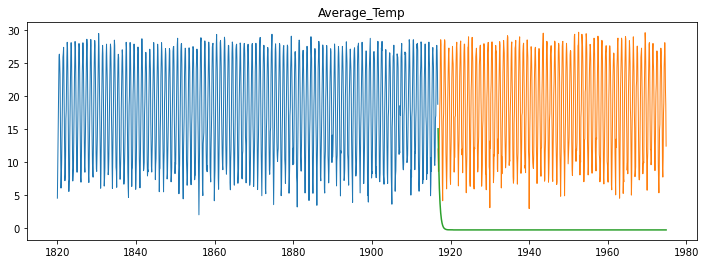

Average_Uncertainty -- RMSE: 0.1266


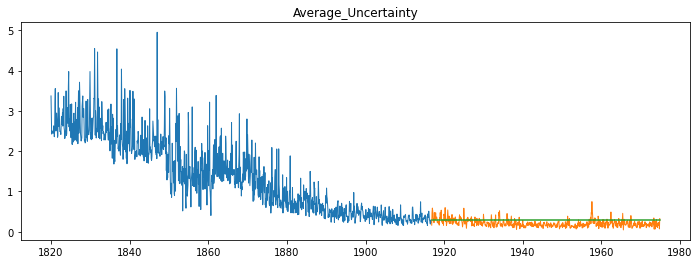

In [64]:
for col in train.columns:
    plot_and_eval(target_var = col)

In [65]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_optimized', 
                            target_var = col)

In [66]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
9,6_month_moving_avg,Average_Uncertainty,0.0983
11,holts_optimized,Average_Uncertainty,0.1266
7,120_month_moving_avg,Average_Uncertainty,0.1414
3,12_month_moving_avg,Average_Uncertainty,0.1492
5,60_month_moving_avg,Average_Uncertainty,0.1492
1,simple_average,Average_Uncertainty,1.1822
6,120_month_moving_avg,Average_Temp,7.3844
0,simple_average,Average_Temp,7.3985
2,12_month_moving_avg,Average_Temp,7.4002
4,60_month_moving_avg,Average_Temp,7.4095


### Modeling on Holt's again with new hyperparameters

In [67]:
for col in train.columns:
    model = Holt(train[col], exponential=False)
    model = model.fit(smoothing_level=.015, 
                      smoothing_slope=.125, 
                      optimized=False)
    yhat_temps = model.predict(start = validate.index[0],
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_temps, 2)

Average_Temp -- RMSE: 12.9808


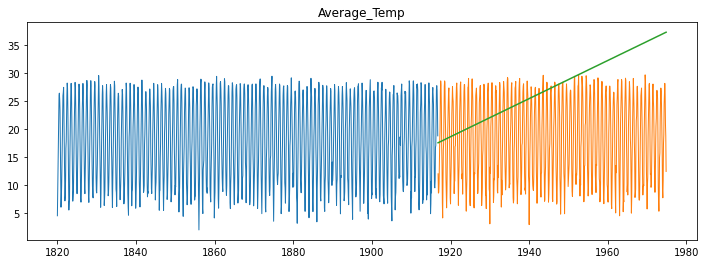

Average_Uncertainty -- RMSE: 0.4463


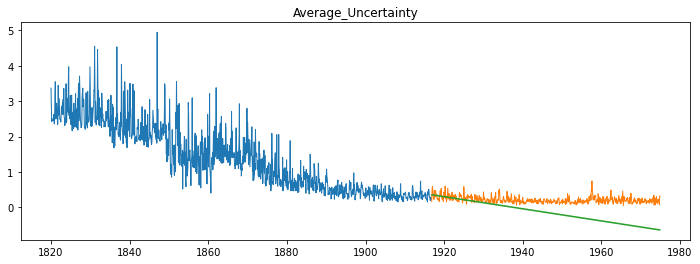

In [68]:
for col in train.columns:
    plot_and_eval(target_var = col)

In [69]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_.1', 
                            target_var = col)
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
9,6_month_moving_avg,Average_Uncertainty,0.0983
11,holts_optimized,Average_Uncertainty,0.1266
7,120_month_moving_avg,Average_Uncertainty,0.1414
3,12_month_moving_avg,Average_Uncertainty,0.1492
5,60_month_moving_avg,Average_Uncertainty,0.1492
13,holts_.1,Average_Uncertainty,0.4463
1,simple_average,Average_Uncertainty,1.1822
6,120_month_moving_avg,Average_Temp,7.3844
0,simple_average,Average_Temp,7.3985
2,12_month_moving_avg,Average_Temp,7.4002


In [70]:
df.tail()

,Average_Temp,Average_Uncertainty
Date,,
2013-05-01,22.628,0.158
2013-06-01,27.841,0.220
2013-07-01,27.630,0.182
2013-08-01,28.663,0.247
2013-09-01,26.408,1.112


### Predict Based on Previous Cycle

Take all the 2016 data points, compute the daily delta, year-over-year, average that delta over all the days, and adding that average to the previous year's value on a day will give you the forecast for that day. 

If a primary cycle is weekly, then you may want to do this on a week-over-week cadence. 

In the below example:  
1. Compute the 365 average year over year differences from 2013 through 2015
2. Add that average delta to the values during 2015. 
3. Set the index in your yhat dataframe to represent the dates those predictions are make for. 

Let's get started....

**Re-split data**

In [71]:
train.tail()

,Average_Temp,Average_Uncertainty
Date,,
1916-06-01,27.134,0.216
1916-07-01,27.693,0.190
1916-08-01,26.943,0.291
1916-09-01,23.658,0.281
1916-10-01,18.745,0.222


In [72]:
# Resplitting data
train = df[:'2010']
validate = df['2011']
test = df['2012']

print(train.shape)
print(validate.shape)
print(test.shape)

train.head()
train.tail()

(2292, 2)
(12, 2)
(12, 2)


,Average_Temp,Average_Uncertainty
Date,,
2010-08-01,29.393,0.285
2010-09-01,25.612,0.140
2010-10-01,19.645,0.113
2010-11-01,13.821,0.194
2010-12-01,9.478,0.206


In [73]:
validate

,Average_Temp,Average_Uncertainty
Date,,
2011-01-01,7.121,0.198
2011-02-01,9.245,0.103
2011-03-01,16.565,0.156
2011-04-01,21.351,0.149
2011-05-01,23.529,0.192
2011-06-01,29.715,0.277
2011-07-01,30.731,0.248
2011-08-01,31.401,0.182
2011-09-01,25.696,0.189


In [74]:
test

,Average_Temp,Average_Uncertainty
Date,,
2012-01-01,10.127,0.238
2012-02-01,10.911,0.150
2012-03-01,17.261,0.155
2012-04-01,21.190,0.244
2012-05-01,24.288,0.176
2012-06-01,28.138,0.273
2012-07-01,28.809,0.259
2012-08-01,28.942,0.266
2012-09-01,25.026,0.211


**Make Predictions**

In [83]:
# finding the year-over-year difference for each day from 2010 to 2012
# taking the mean, and then adding that value to the monthly values. 

# find yoy diff. from 2010-2011 and 2011-2012, take the mean, and add to each value in 2015. 
yhat_df = train['2010'] + train.diff(12).mean()
yhat_df

,Average_Temp,Average_Uncertainty
Date,,
2010-01-01,6.75622,0.108275
2010-02-01,6.61722,0.112275
2010-03-01,12.74922,0.209275
2010-04-01,18.46522,0.092275
2010-05-01,23.41622,0.142275
2010-06-01,28.37022,0.149275
2010-07-01,27.71722,0.209275
2010-08-01,29.40122,0.272275
2010-09-01,25.62022,0.127275


Back to predictions

In [84]:
train.loc['2010'].head()

,Average_Temp,Average_Uncertainty
Date,,
2010-01-01,6.748,0.121
2010-02-01,6.609,0.125
2010-03-01,12.741,0.222
2010-04-01,18.457,0.105
2010-05-01,23.408,0.155


In [85]:
yhat_df.head()

,Average_Temp,Average_Uncertainty
Date,,
2010-01-01,6.75622,0.108275
2010-02-01,6.61722,0.112275
2010-03-01,12.74922,0.209275
2010-04-01,18.46522,0.092275
2010-05-01,23.41622,0.142275


In [87]:
# let's peek into the prediction we will make for 1/1/2011
# by comparing the predicted value 
# (2010 value + year-over-year average difference)
# to the actual 1/1/2011 value
pd.concat([yhat_df.head(1), validate.head(1)])

,Average_Temp,Average_Uncertainty
Date,,
2010-01-01,6.75622,0.108275
2011-01-01,7.12100,0.198000


In [88]:
# set yhat_df to index of validate

yhat_df.index = validate.index
yhat_df

,Average_Temp,Average_Uncertainty
Date,,
2011-01-01,6.75622,0.108275
2011-02-01,6.61722,0.112275
2011-03-01,12.74922,0.209275
2011-04-01,18.46522,0.092275
2011-05-01,23.41622,0.142275
2011-06-01,28.37022,0.149275
2011-07-01,27.71722,0.209275
2011-08-01,29.40122,0.272275
2011-09-01,25.62022,0.127275


In [89]:
yhat_df.describe()

,Average_Temp,Average_Uncertainty
count,12.000000,12.000000
mean,18.506803,0.158108
std,8.488843,0.055256
min,6.617220,0.092275
25%,11.933470,0.111275
50%,19.059220,0.145775
75%,26.144470,0.197275
max,29.401220,0.272275


In [90]:
yhat_df.head()

,Average_Temp,Average_Uncertainty
Date,,
2011-01-01,6.75622,0.108275
2011-02-01,6.61722,0.112275
2011-03-01,12.74922,0.209275
2011-04-01,18.46522,0.092275
2011-05-01,23.41622,0.142275


In [91]:
yhat_df.shape

(12, 2)

**Plot and Evaluate**

Average_Temp -- RMSE: 1.9960


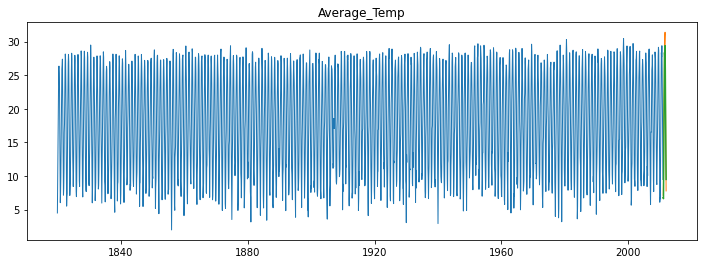

Average_Uncertainty -- RMSE: 0.0673


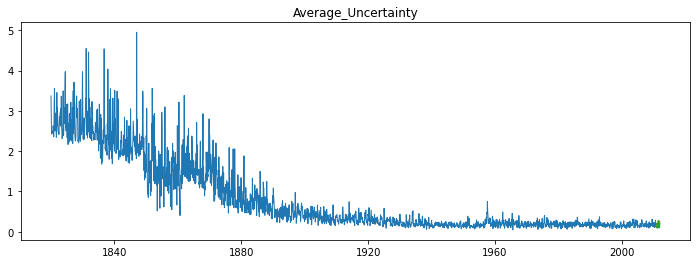

In [92]:
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = "previous_year", 
                            target_var = col)

In [93]:
temps_min_rmse = eval_df.groupby('target_var')['rmse'].min()[0]

uncert_min_rmse = eval_df.groupby('target_var')['rmse'].min()[1]

# find which model that is
eval_df[((eval_df.rmse == temps_min_rmse) | 
         (eval_df.rmse == uncert_min_rmse))]

,model_type,target_var,rmse
14,previous_year,Average_Temp,1.9960
15,previous_year,Average_Uncertainty,0.0673


Let's test it out on our out-of-sample data

We will be using train + validate to predict test. 

In [94]:
yhat_df = validate + train.diff(12).mean()
yhat_df.index = test.index

In [95]:
yhat_df

,Average_Temp,Average_Uncertainty
Date,,
2012-01-01,7.12922,0.185275
2012-02-01,9.25322,0.090275
2012-03-01,16.57322,0.143275
2012-04-01,21.35922,0.136275
2012-05-01,23.53722,0.179275
2012-06-01,29.72322,0.264275
2012-07-01,30.73922,0.235275
2012-08-01,31.40922,0.169275
2012-09-01,25.70422,0.176275


In [96]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], label='train')
    plt.plot(validate[target_var], label='validate')
    plt.plot(test[target_var], label='test')
    plt.plot(yhat_df[target_var], alpha=.5)
    plt.title(target_var)

    plt.show()

In [98]:
test

,Average_Temp,Average_Uncertainty
Date,,
2012-01-01,10.127,0.238
2012-02-01,10.911,0.150
2012-03-01,17.261,0.155
2012-04-01,21.190,0.244
2012-05-01,24.288,0.176
2012-06-01,28.138,0.273
2012-07-01,28.809,0.259
2012-08-01,28.942,0.266
2012-09-01,25.026,0.211


In [100]:
rmse_temps = sqrt(mean_squared_error(test['Average_Temp'], 
                                       yhat_df['Average_Temp']))

rmse_uncert = sqrt(mean_squared_error(test['Average_Uncertainty'], 
                                       yhat_df['Average_Uncertainty']))

In [101]:
print('rmse-average-temp: ', rmse_temps)
print('rmse-average-uncert: ', rmse_uncert)

rmse-average-temp:  1.6900169152179736
rmse-average-uncert:  0.05798125235798207


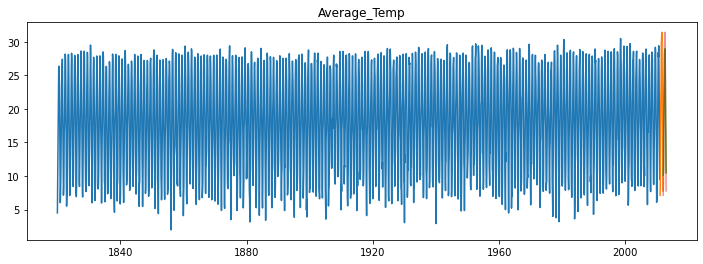

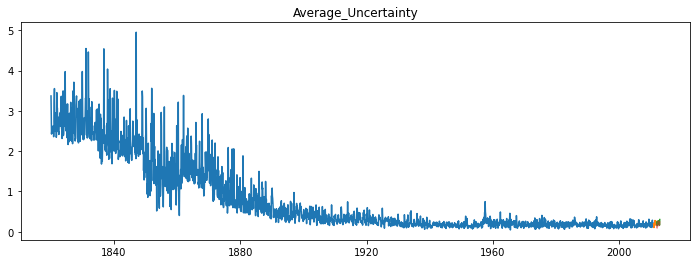

In [102]:
for col in train.columns:
    final_plot(col)

In [109]:
import datetime as dt

def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], label='train')
    plt.plot(validate[target_var], label='validate')
    plt.plot(test[target_var], label='test')
    plt.plot(yhat_df[target_var], alpha=.5)
    plt.title(target_var)
    left = dt.date(2000, 3, 15)
    right = dt.date(2015, 7, 15)
    plt.gca().set_xbound(left, right)
    plt.show()

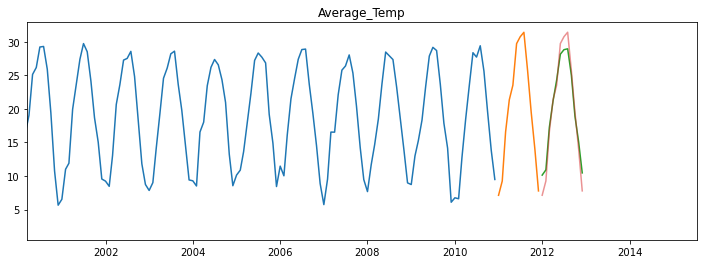

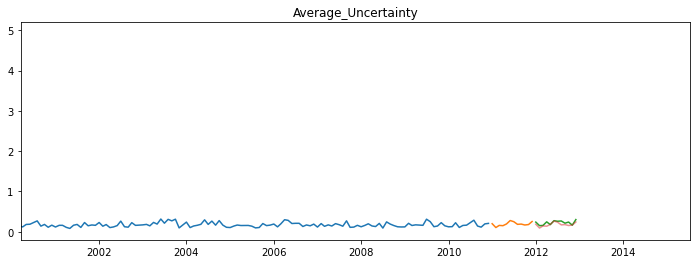

In [110]:
for col in train.columns:
    final_plot(col)

### Conclusion

Which model did the best?

In [111]:
temps_min_rmse = eval_df.groupby('target_var')['rmse'].min()[0]

uncert_min_rmse = eval_df.groupby('target_var')['rmse'].min()[1]

# find which model that is
eval_df[((eval_df.rmse == temps_min_rmse) | 
         (eval_df.rmse == uncert_min_rmse))]

,model_type,target_var,rmse
14,previous_year,Average_Temp,1.9960
15,previous_year,Average_Uncertainty,0.0673


In [115]:
# to predict upcoming year 
yhat_df = test + train.diff(12).mean()
yhat_df.index = test.index + pd.Timedelta('1Y')

In [116]:
yhat_df

,Average_Temp,Average_Uncertainty
Date,,
2012-12-31 05:49:12,10.13522,0.225275
2013-01-31 05:49:12,10.91922,0.137275
2013-03-01 05:49:12,17.26922,0.142275
2013-04-01 05:49:12,21.19822,0.231275
2013-05-01 05:49:12,24.29622,0.163275
2013-06-01 05:49:12,28.14622,0.260275
2013-07-01 05:49:12,28.81722,0.246275
2013-08-01 05:49:12,28.95022,0.253275
2013-09-01 05:49:12,25.03422,0.198275


In [125]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], label='train')
    plt.plot(validate[target_var], label='validate')
    plt.plot(test[target_var], label='test')
    plt.plot(yhat_df[target_var], alpha=.5)
    plt.title(target_var)
    left = dt.date(1970, 3, 15)
    right = dt.date(2015, 7, 15)
    plt.gca().set_xbound(left, right)
    plt.show()

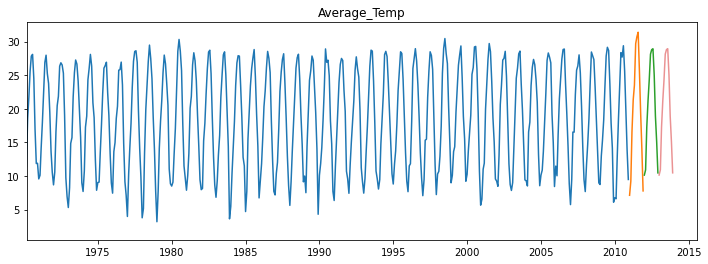

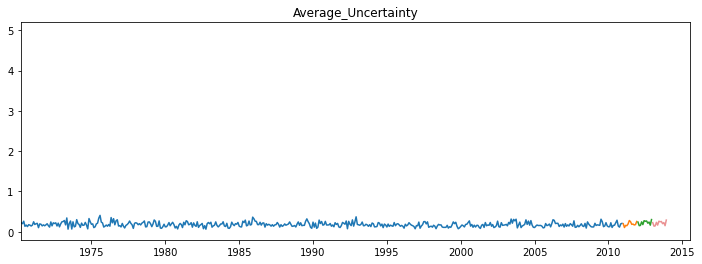

In [126]:
for col in train.columns:
    final_plot(col)